In [323]:

import pandas as pd
import seaborn as sns
import pickle
from d3blocks import D3Blocks    
import matplotlib.pyplot as plt
import numpy as np
import anndata as ad
from mpl_chord_diagram import chord_diagram
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

## load data

In [362]:
F=open(r'D:\project\pathway\spatalk_plus\CytoTour\cci_result.pkl','rb')
content=pickle.load(F)
lr_score = content["lr_score"]
pair_distance = content["pair_distance"]


### color config

In [348]:
def nor_color(cor_list):
    return [x/255 for x in cor_list]
def get_color(l_len=3,r_len=3,theme = "BuGu"):
    color_dict={}
    if theme == "BuGu":
        cmap = plt.cm.jet
        lc1 = nor_color([0, 0, 139])
        lc2 = nor_color([110,204,175])
        lmaplist = [lc1, lc2]
        rc1 = nor_color([251, 215, 134])
        rc2 = nor_color([249, 212, 35])
        rmaplist = [rc1, rc2]
        lcmap = cmap.from_list('ligand color', lmaplist, l_len)
        lcolors = lcmap(np.linspace(0, 1, l_len))
        rcmap = cmap.from_list('receptor color', rmaplist, r_len)
        rcolors = rcmap(np.linspace(0, 1, r_len))
        colors = np.vstack((rcolors,lcolors))
        newcmp = ListedColormap(colors, name='lr')
        my_pal = {"lrdb": "#FFD166", "novel": "#00A896", "cell_pair": "#BE5A83"}
        heatmapcolor = sns.cubehelix_palette(8,start=.0,rot=-0.3,gamma=1,dark=0.3,light=1)

    color_dict["chord"] = newcmp
    color_dict["violin"] = my_pal
    color_dict["heatmap"] = heatmapcolor
    return color_dict
    

## plot distribution plot to show cell pair distance in different groups

In [411]:
def plot_distribution(pair_distance,lr_score,adata_path,key="all"):
    """
    get the distance distribution between different group.

    args:
        pair_distance: the pair distance dataframe.
        lr_score: the lr_score dataframe.
        adata_path: the sc data file.
        key: control plot type, "violine" or "kde" or "all".
    """
    merged_df = pd.merge(pair_distance, lr_score, left_on=['sender_type', 'receiver_type'],right_on=['cell_sender', 'cell_receiver'])
    merged_df.sort_values("cell_sender_x",inplace=True)
    adata = ad.read_h5ad(adata_path)
    st_data = adata.to_df()
    sender = list(set(merged_df['cell_sender_x'].values.tolist()))
    genes = st_data.columns.values
    st_data = st_data.transpose()
    lr_dist= pd.DataFrame(columns=merged_df.columns.values)
    for i in sender:
        exp_genes = st_data[(st_data.loc[:,i]>0)].index.tolist()
        ligand = merged_df[(merged_df['cell_receiver_x']==i)]["ligand"].values.tolist()
        keeped_ligand = list(set(exp_genes).intersection(set(ligand)))
        data = merged_df[(merged_df['ligand'].isin(keeped_ligand))&(merged_df['cell_sender_x']==i)]
        lr_dist = pd.concat([lr_dist, data], axis=0)

    for i in sender:
        exp_genes = st_data[(st_data.loc[:,i]>0)].index.tolist()
        ligand = merged_df[(merged_df['cell_receiver_x']==i)]["receptor"].values.tolist()
        keeped_ligand = list(set(exp_genes).intersection(set(ligand)))
        data = merged_df[(merged_df['receptor'].isin(keeped_ligand))&(merged_df['cell_receiver_x']==i)]
        lr_dist = pd.concat([lr_dist, data], axis=0)   

    merged_df["is_expressed"] = "False"
    merged_df["is_novel"] = "lrdb"
    new_data=merged_df.copy()
    new_data["is_expressed"].iloc[lr_dist.index.values.tolist()]= "True"
    new_data["sender-receiver"] = new_data["sender_type"].str.split('_',expand=True)[0]+"-"+new_data["receiver_type"].str.split('_',expand=True)[0]
    new_data.loc[new_data['type'].isin(['L','R','LR']), 'is_novel']= "novel"
    new_data.sort_values("sender-receiver",inplace=True)
    ret_data = new_data.copy()
    ret_data.loc[:,'is_novel'] = "cell_pair"
    new_data = pd.concat([new_data, ret_data], axis=0)
    new_data=new_data.reset_index(drop=True)
    new_data.loc[100:900,"is_novel"] = 'lrdb'
    if key == "violine":
        plt.figure(figsize=(12, 6))
        vio_color = get_color()["violin"]
        sns.violinplot(data=new_data, x="sender-receiver", y="distance", hue="is_novel",palette=vio_color)
        plt.xticks(fontsize=6, rotation=45)
    if key == "kde":
        vio_color = get_color()["violin"]  
        sns.kdeplot(
            data=new_data, x="distance", hue="is_novel",
            fill=True, common_norm=False, palette=vio_color,
            alpha=.6, linewidth=0,
        )
    else:
        fig, ax = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [.75, .25]})
        
        vio_color = get_color()["violin"]
        sns.violinplot(data=new_data, x="sender-receiver", y="distance", hue="is_novel",palette=vio_color,ax=ax[0])
        ax[0].tick_params(axis='x', rotation=20)
        sns.kdeplot(
            data=new_data, x="distance", hue="is_novel",
            fill=True, common_norm=False, palette=vio_color,
            alpha=.5, linewidth=0,ax=ax[1]
            )
                    



test

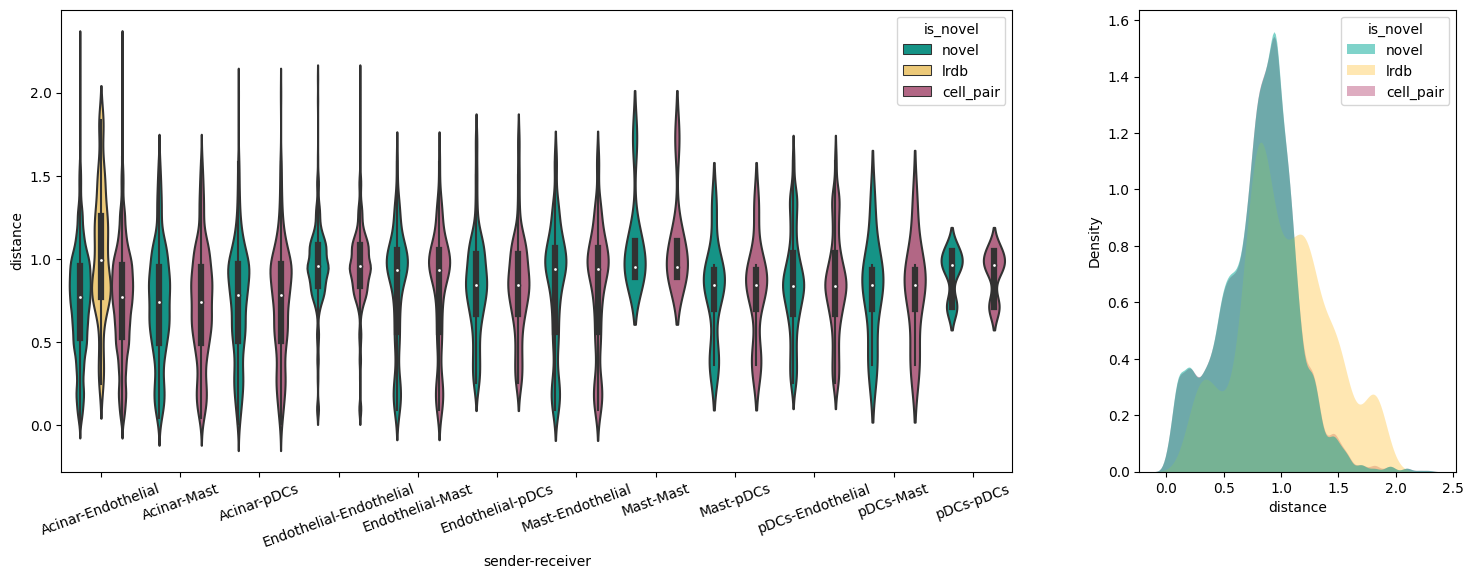

In [412]:
plot_distribution(pair_distance,lr_score,r"D:\project\pathway\spatalk_plus\CytoTour\demo\pdac.h5ad")

## plot chrod to show ligand receptor interaction

In [203]:
def plot_chord(lr_score,sender,receiver,k):
    """
    get the ligand receptor interaction plot.

    args:
        lr_score: the lr_score dataframe.
        sender: the cell type sender.
        receiver: the cell type receiver.
        top_k: show the top k lr pair (ranked by lr_score).
    """
    plot_data = lr_score.loc[(lr_score['cell_sender']==sender)&(lr_score['cell_receiver']==receiver)]
    if k > plot_data.shape[0]:
        k = plot_data.shape[0]
    plot_data.sort_values("lr_score",inplace=True)
    plot_data = plot_data.head(k)
    plot_data = plot_data[["ligand","receptor","lr_score"]]
    # Get unique gene names from both gene1 and gene2 columns
    genes = list(set(plot_data['ligand'].tolist() + plot_data['receptor'].tolist()))
    l_len = len(list(set(plot_data['ligand'].tolist())))
    r_len = len(list(set(plot_data['receptor'].tolist())))
    flux = np.zeros((len(genes), len(genes)))
    gaps = []
    # Update the interaction matrix with the scores
    for _, row in plot_data.iterrows():
        i = genes.index(row['ligand'])
        j = genes.index(row['receptor'])
        flux[i, j] = row['lr_score']
        flux[j, i] = row['lr_score']
    newcmp = get_color(l_len,r_len)["chord"]
    fig,ax = plt.subplots(figsize=(6,6),dpi=100,facecolor="w")
    chord_diagram(flux, genes, ax=ax, gap=0.02, nrota=True,directed=False,alpha=0.8,cmap= newcmp)
    plt.tight_layout()
    
        

test

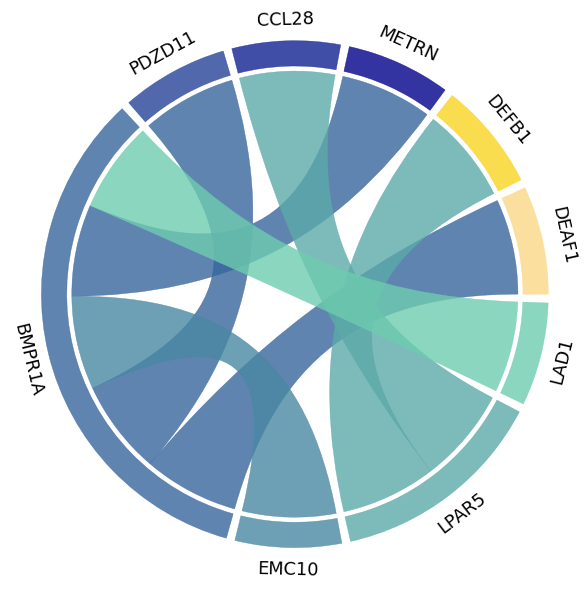

In [204]:
plot_chord(lr_score,"Acinar_cells","Mast_cells",10)

## plot heatmap to show ligand receptor interaction times in different cell pair

In [409]:
def plot_heatmap(lr_score,k=10,min_score=0.5,min_times=2):
    """
    get the ligand receptor interaction plot.

    args:
        lr_score: the lr_score dataframe.
        k: int, the number of lr pair to show (ranked by score).
        min_score: float, the value of cutoff score.
        min_times: int, the value of cutoff siginificant times.
    """
    lr_score.sort_values(by='score',ascending=False,inplace=True)
    heat_color = get_color()["heatmap"]
    data_draw = lr_score.loc[lr_score["score"] > min_score-0.000001]
    data_draw_new = data_draw.groupby(["ligand","receptor"]).size().reset_index()
    data_draw_new.columns = ["ligand","receptor","times"]
    data_draw_new=data_draw_new.loc[data_draw_new['times']>=min_times]
    data_draw_new = data_draw_new.head(k)
    df0 = pd.DataFrame(
        columns=list(set(data_draw_new['ligand'].values)), 
        index=list(set(data_draw_new['receptor'].values))
    ) 
    for i in range(data_draw_new.shape[0]):
        row = data_draw_new.iloc[i,:]
        receptor = row['receptor']
        ligand = row['ligand']
        df0.loc[receptor,ligand] = row['times']
    df0 = df0.replace(np. nan,0)
    novel_r = data_draw[data_draw['type'].str.contains('R')]
    novel_r=list(set(novel_r["receptor"]))
    novel_l = data_draw[data_draw['type'].str.contains('L')]
    novel_l=list(set(novel_l["ligand"]))
    retB = list(set(novel_l).intersection(set(df0.columns)))
    fig, ax = plt.subplots(figsize=(10,5))  
    sns.heatmap(df0,cmap=heat_color,square=True,linewidth=0.1, linecolor=(0.1,0.2,0.2),cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
    ax.get_yticklabels()[0].set_color("#501dBa")
    ax.get_yticklabels()[1].set_color("#501dBa")
    #ax.set_yticklabels(ax.get_yticklabels(),rotation = 45)
    plt.xlabel('ligand')
    plt.ylabel('receptor')
    for i in retB:
        ind = list(df0.columns).index(i)
        ax.get_xticklabels()[ind].set_color("#501dBa")
    #cb = ax.figure.colorbar(ax.collections[0],location='bottom',pad=0.05,aspect=10,shrink=0.1,label='score')
    cbaxes = fig.add_axes([0.12, 0.15, 0.05, 0.05]) 
    ax.figure.colorbar(ax.collections[0],pad=0.8,fraction=0.01,label='times',cax = cbaxes,orientation="horizontal")

test

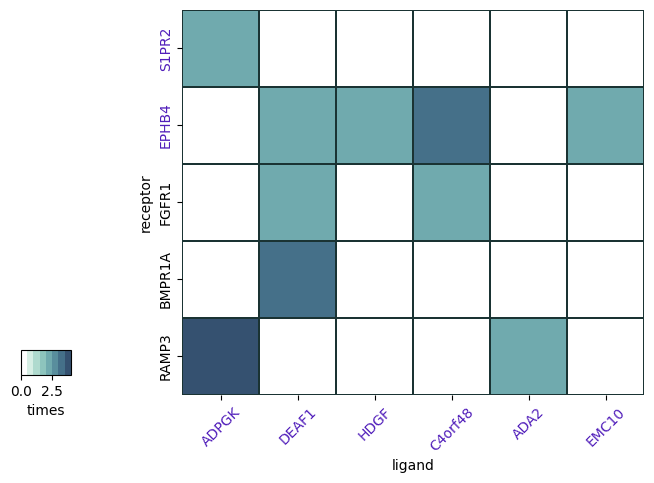

In [410]:
plot_heatmap(lr_score,10)